# import thư viện

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

# load data

In [2]:
df_btc = pd.read_csv('/Users/dophi/Desktop/LSTM_ETH/Get_data/data/BTCUSDT_1d.csv')
df_btc.head(5)

,open_time,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,ignore
0,1502928000000,4261.48,4485.39,4200.74,4285.08,795.150377,1503014399999,3.454770e+06,3427,616.248541,2.678216e+06,8733.911395
1,1503014400000,4285.08,4371.52,3938.77,4108.37,1199.888264,1503100799999,5.086958e+06,5233,972.868710,4.129123e+06,9384.141409
2,1503100800000,4108.37,4184.69,3850.00,4139.98,381.309763,1503187199999,1.549484e+06,2153,274.336042,1.118002e+06,9184.085529
3,1503187200000,4120.98,4211.08,4032.62,4086.29,467.083022,1503273599999,1.930364e+06,2321,376.795947,1.557401e+06,10125.414084
4,1503273600000,4069.13,4119.62,3911.79,4016.00,691.743060,1503359999999,2.797232e+06,3972,557.356107,2.255663e+06,11706.769970


In [3]:
df_eth = pd.read_csv('/Users/dophi/Desktop/LSTM_ETH/Get_data/data/ETHUSDT_1d.csv')
df_eth.head(5)

,open_time,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,ignore
0,1502928000000,301.13,312.18,298.00,302.00,7030.71034,1503014399999,2.154655e+06,4522,6224.58999,1.908705e+06,50579.872288
1,1503014400000,302.00,311.79,283.94,293.96,9537.84646,1503100799999,2.858947e+06,5658,7452.43542,2.240813e+06,55329.574324
2,1503100800000,293.31,299.90,278.00,290.91,2146.19773,1503187199999,6.200226e+05,1795,1537.97550,4.447136e+05,58005.171046
3,1503187200000,289.41,300.53,282.85,299.10,2510.13871,1503273599999,7.428479e+05,2038,2186.68739,6.475061e+05,60299.066154
4,1503273600000,299.10,346.52,294.60,323.29,5219.44542,1503359999999,1.689472e+06,3925,4004.19967,1.297977e+06,66203.840222


# EDA

## loại bỏ các cột không cần thiết

In [4]:
df_btc = df_btc.drop(['close_time', 'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore' ], axis=1)
df_eth = df_eth.drop(['close_time', 'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore' ], axis=1)

In [5]:
df_btc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3021 entries, 0 to 3020
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   open_time  3021 non-null   int64  
 1   open       3021 non-null   float64
 2   high       3021 non-null   float64
 3   low        3021 non-null   float64
 4   close      3021 non-null   float64
 5   volume     3021 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 141.7 KB


In [6]:
df_eth.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3021 entries, 0 to 3020
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   open_time  3021 non-null   int64  
 1   open       3021 non-null   float64
 2   high       3021 non-null   float64
 3   low        3021 non-null   float64
 4   close      3021 non-null   float64
 5   volume     3021 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 141.7 KB


Dữ liệu đầy đủ và không bị thiếu

# định dạng lại dữ liệu thời gian

In [7]:
df_btc['open_time'].describe()

count    3.021000e+03
mean     1.908434e+14
std      5.432237e+14
min      1.502928e+12
25%      1.568160e+12
50%      1.633392e+12
75%      1.698624e+12
max      1.763856e+15
Name: open_time, dtype: float64

dữ liệu từ 2017 → 2025, timestamp dạng milliseconds (ms).

Nhưng trong cột open_time có một số giá trị quá lớn:

Giá trị đúng: ~1.5e12 → 1.7e12

Giá trị sai: ~1.7e15 (lớn gấp 1000 lần)

Chia bớt 1000 cho những dòng timestamp bất thường

Timestamp đúng của năm 2017–2025 chỉ nằm khoảng 1.5e12 → 1.75e12.
Vậy nên bất kỳ giá trị nào > 2e12 chắc chắn là lỗi (bị nhân nhầm ×1000).

=> 2,000,000,000,000 được dùng làm ngưỡng để nhận diện timestamp sai.

In [8]:
mask = df_btc['open_time'] > 2_000_000_000_000
df_btc.loc[mask, 'open_time'] = df_btc.loc[mask, 'open_time'] // 1000

In [9]:
df_btc['open_time'] = pd.to_datetime(df_btc['open_time'], unit='ms')

In [10]:
df_btc.sample(5)

,open_time,open,high,low,close,volume
2005,2023-02-12,21862.02,22090.00,21630.00,21783.54,204435.651630
2110,2023-05-28,26854.28,28261.32,26764.36,28065.00,43916.008550
776,2019-10-02,8292.67,8373.91,8151.22,8359.94,26243.386644
2559,2024-08-19,58427.35,59617.63,57787.30,59438.50,22809.312510
1110,2020-08-31,11711.17,11800.77,11570.00,11649.51,55353.617744


In [11]:
mask = df_eth['open_time'] > 2_000_000_000_000
df_eth.loc[mask, 'open_time'] = df_eth.loc[mask, 'open_time'] // 1000

In [12]:
df_eth['open_time'] = pd.to_datetime(df_eth['open_time'], unit='ms')

In [13]:
df_eth.sample(5)

,open_time,open,high,low,close,volume
2377,2024-02-19,2881.20,2984.52,2856.93,2944.80,446451.04010
2176,2023-08-02,1873.48,1879.74,1821.21,1839.90,254213.05530
291,2018-06-04,619.66,625.47,580.15,591.02,96339.44507
2995,2025-10-29,3979.19,4036.66,3840.37,3902.99,486452.31270
265,2018-05-09,748.99,760.74,710.26,751.75,112353.37758


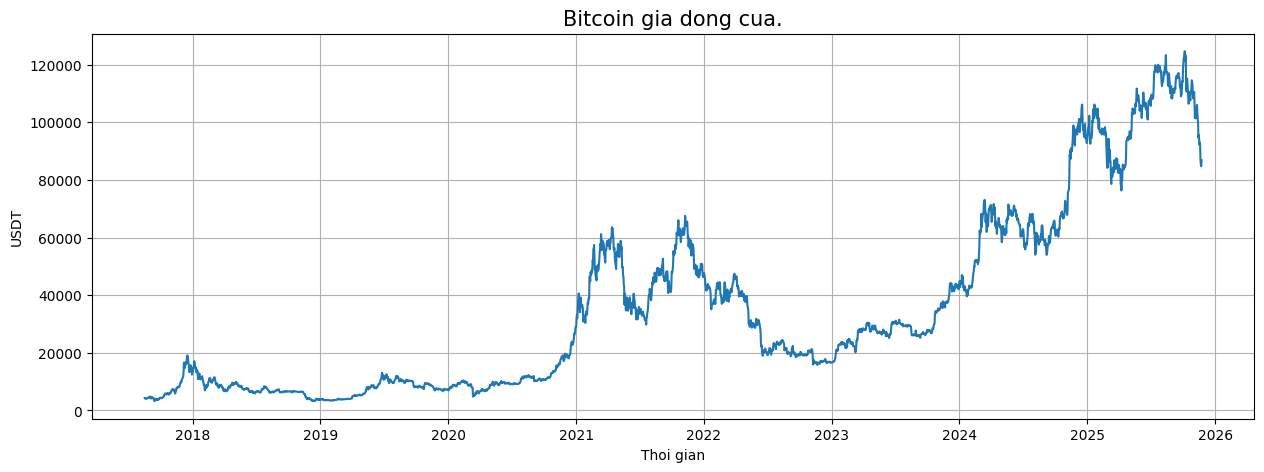

In [14]:
plt.figure(figsize=(15, 5))
plt.plot(df_btc['open_time'], df_btc['close'])
plt.title('Bitcoin gia dong cua.', fontsize=15)
plt.ylabel('USDT')
plt.xlabel('Thoi gian')
plt.grid("--")
plt.show()

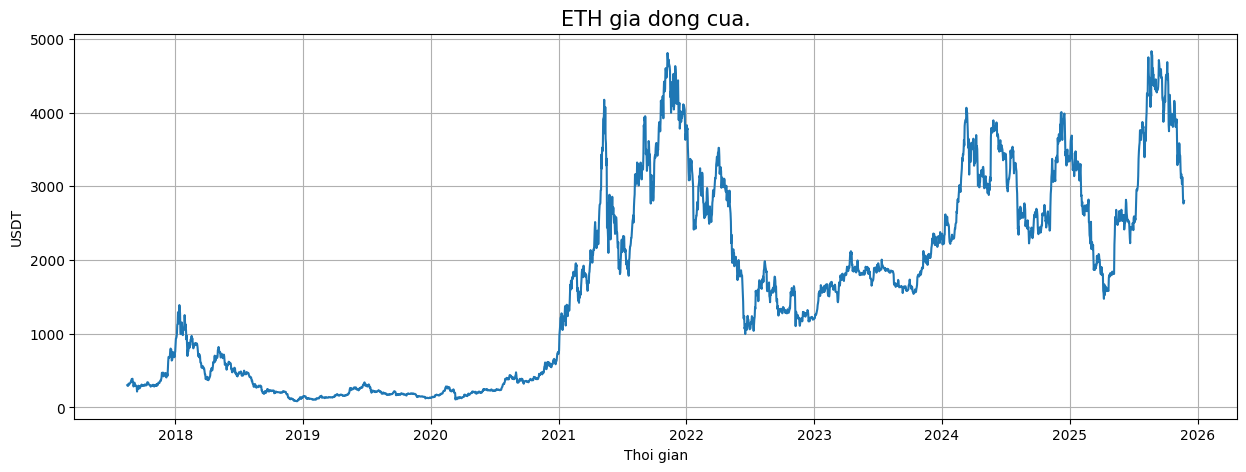

In [15]:
plt.figure(figsize=(15, 5))
plt.plot(df_eth['open_time'], df_eth['close'])
plt.title('ETH gia dong cua.', fontsize=15)
plt.ylabel('USDT')
plt.xlabel('Thoi gian')
plt.grid("--")
plt.show()

khi nhìn vào biểu đồ giá đóng cửa của BTC và ETH có thể dễ dàng nhận thấy cả hai đều có xu hướng tăng giá dài hạn. và có những khoảng điều chỉnh sau khi tăng rồi tiếp tục tăng. cho thấy chu kỳ tăng giá của thị trường tiền điện tử.

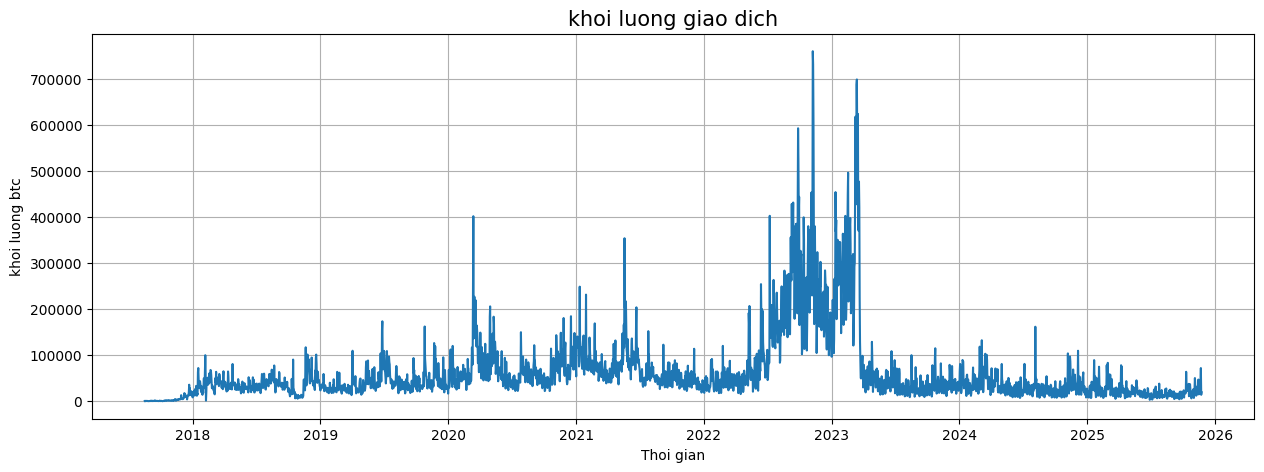

In [16]:
plt.figure(figsize=(15, 5))
plt.plot(df_btc['open_time'], df_btc['volume'])
plt.title('khoi luong giao dich', fontsize=15)
plt.ylabel('khoi luong btc')
plt.xlabel('Thoi gian')
plt.grid("--")
plt.show()

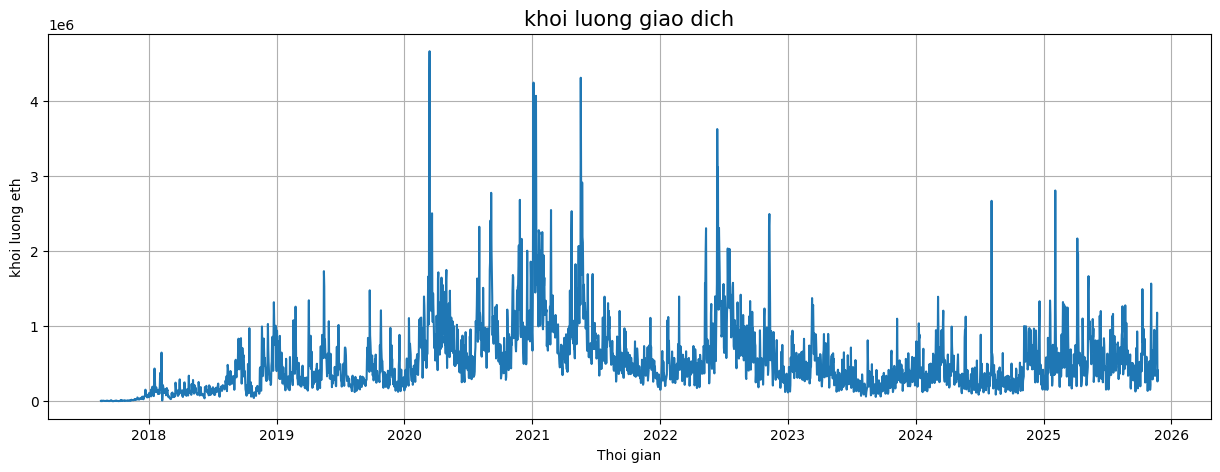

In [17]:
plt.figure(figsize=(15, 5))
plt.plot(df_eth['open_time'], df_eth['volume'])
plt.title('khoi luong giao dich', fontsize=15)
plt.ylabel('khoi luong eth')
plt.xlabel('Thoi gian')
plt.grid("--")
plt.show()

Quan sát biểu đồ khối lượng cho thấy vùng đỉnh biến động mạnh đầu tiên của cả 2 cặp tiền là ở đoạn 2020-2021, để giải thích điều này có thể liên quan đến các sự kiện lớn trong thị trường tiền điện tử như:
- Bitcoin Halving ngày 11/05/2020, dẫn đến việc giảm nguồn cung và tăng giá.
- Kết hợp với bối cảnh đại dịch COVID-19 khiến Cục Dự trữ Liên bang Mỹ (Fed) bơm tiền quy mô lớn từ tháng 3/2020, tạo động lực cho dòng vốn đổ vào các tài sản rủi ro như Bitcoin và Ethereum.
- Đến năm 2021, crypto tiếp tục nhận được sự chú ý mạnh mẽ khi Tesla công bố vào ngày 08/02/2021 rằng họ đã mua 1,5 tỷ USD Bitcoin, góp phần đẩy volume giao dịch lên mức rất cao và đưa giá lên đỉnh lịch sử thời điểm đó.
- NFT bùng nổ từ tháng 02–08/2021 đã khiến lượng giao dịch trên mạng Ethereum tăng vọt.

Tiếp theo là giai đoạn giữa năm 2022 đến cuối năm 2022 và đầu năm 2023, nhưng trái ngược với trước đó giai đoạn này thể hiện sự khủng hoảng của thị trường như:
- LUNA–UST sụp đổ vào ngày 12/05/2022, LUNA gần như về 0 chỉ trong vài ngày, gây ra làn sóng bán tháo trên toàn thị trường.
- Chưa kịp phục hồi sau cú sập LUNA diễn tiếp sự khủng hoảng như một hiệu ứng domino sàn FTX phá sản ngày 11/11/2022 một cú sốc lớn làm xuất hiện nhiều đỉnh volume bất thường do nhà đầu tư hoảng loạn rút tiền và thanh lý tài sản hàng loạt.

- Bước sang năm 2024, thị trường hồi phục trở lại với sự góp mặt của các tổ chức tài chính truyền thống sau khi Ủy ban Chứng khoán Mỹ (SEC) phê duyệt ETF Bitcoin Spot vào ngày 10/01/2024, giúp tăng dòng vốn đổ vào thị trường, dù volume không đạt mức cực đại như giai đoạn 2021 hay 2022. Tiếp theo đó, Bitcoin Halving lần thứ 4 diễn ra ngày 20/04/2024, tiếp tục củng cố xu hướng quan tâm trở lại của nhà đầu tư. Tuy nhiên, volume giai đoạn này ổn định hơn và không còn quá đột biến, phản ánh thị trường trưởng thành hơn so với các chu kỳ trước.

Liên hệ từ biểu đồ giá và khối lượng giao dịch cũng có thể thấy chúng cũng có sự liên quan lẫn nhau, những khi khối lượng giao dịch tăng đột biến thường đi kèm với những biến động lớn về giá, có thể là tăng hoặc giảm.

In [ ]:
df_btc.to_csv('/Users/dophi/Desktop/LSTM_ETH/eda/BTCUSDT_1d_cleaned.csv', index=False)
df_eth.to_csv('/Users/dophi/Desktop/LSTM_ETH/eda/ETHUSDT_1d_cleaned.csv', index=False)